# **분석 배경**  
OO공장의 고객사에서 최근 들어 **"Scale 불량 발생 증가"**라는 이슈가 발생했다.   
그래서 그 원인을 분색하 본 결과 **압연공정에서 Scale불량이 급증**한 것을 확인할 수 있었다.

그래서 데이터를 수집하여 **다양한 분석을 통해 불량 발생의 근본 원인을 찾고 개선을 위한 최적의 조건을 도출**하고자 한다.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF사용을 위한 라이브러리
from sklearn.model_selection import train_test_split # 데이터를 train과 test로 나누기 위한 라이브러리

from sklearn.preprocessing import StandardScaler # 데이터 스케일링 (표준화(Standardization))를 위한 라이브러리

from statsmodels.api import Logit # 로지스틱 회귀를 위한 라이브러리
import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier # 의사결정나무를 위한 라이브러리
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트를 위한 라이브러리
from sklearn.ensemble import GradientBoostingClassifier # 그래디언트부스팅을 위한 라이브러리
from sklearn.neural_network import MLPClassifier # 
from sklearn.svm import SVC # SVM을 위한 라이브러리
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import GridSearchCV

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN

mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family = 'Malgun Gothic')
plt.rc('font', family='NanumGothic') 

plt.rc('axes', unicode_minus=False)

## **데이터 불러오기**

In [15]:
df_raw = pd.read_csv("./SCALE불량.csv", engine = "python", encoding='CP949')
df_raw_x = df_raw.drop(["SCALE"], axis = 1, inplace = False) # 설명 변수 
df_raw_y = df_raw["SCALE"] # 목표 변수
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


## **데이터 구조 파악**

In [16]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

데이터 형태 : 720 X 21

#### 1) 결측치 확인
결측치 존재하지 않음

In [17]:
df_raw.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

## **변수별 요약 통계량 확인**


In [18]:
df_raw.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.527778,1149.666667,78.802778,300.563889,1149.666667,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,37.660799,17.571788,36.421004,45.390303,17.571788,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1113.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1132.000000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1155.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,342.000000,1164.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,398.000000,1185.000000,1078.000000,10.000000


수치형 데이터의 통계 분포가 매우 다양하기 때문에 스케일링을 진행하고자 한다.

## **변수 설명**
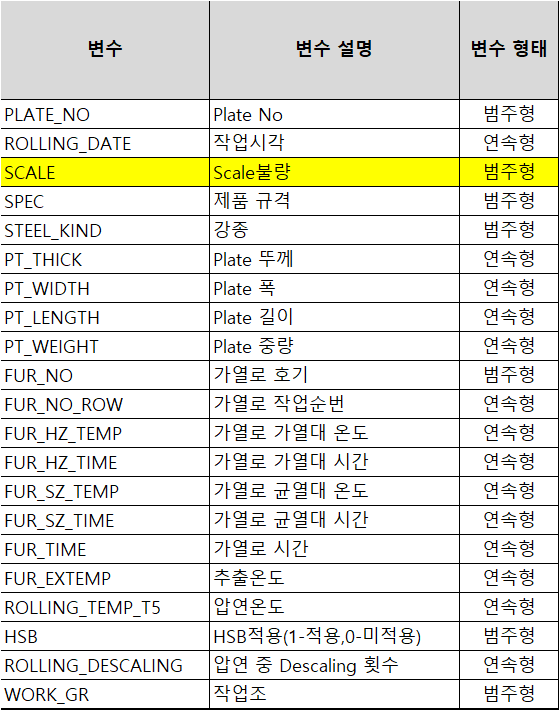

## **데이터 정제**


### 1) 데이터 삭제
행 데이터 마다 가지는 판의 고유 번호인 **PLATE_NO**과 작업 시간에 해당하는 **ROLLING_DATE**를 삭제한다.

In [19]:
df_raw.drop(["PLATE_NO", "ROLLING_DATE"], axis = 1, inplace = True)
df_raw.columns

Index(['SCALE', 'SPEC', 'STEEL_KIND', 'PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT',
       'FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP',
       'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'HSB',
       'ROLLING_DESCALING', 'WORK_GR'],
      dtype='object')

### 2) 데이터 치환
명목형인 목표변수 **SCALE** 변수를 불량일때 1, 양품일때 0으로 치환한다. 

In [20]:
df_raw['SCALE'] = np.where(df_raw['SCALE'] == "불량", 1, 0)
df_raw['SCALE'].value_counts()

0    489
1    231
Name: SCALE, dtype: int64

### 2-2) 설명변수와 목표변수 나누기

In [21]:
df_raw_x = df_raw.drop(["SCALE"], axis = 1, inplace = False) # 설명 변수 
df_raw_y = df_raw["SCALE"] # 목표 변수

### 3) 데이터 분류 (명목형)
데이터 중 명목형 columns를 분류한다.

In [22]:
df_object = df_raw_x.select_dtypes(include = 'object')
obj_cols = df_object.columns
obj_cols

Index(['SPEC', 'STEEL_KIND', 'FUR_NO', 'HSB', 'WORK_GR'], dtype='object')

In [23]:
for col in obj_cols:
    _n = len(df_raw[col].value_counts()) 
    print(col, ":", str(_n))

SPEC : 66
STEEL_KIND : 9
FUR_NO : 3
HSB : 2
WORK_GR : 4


'SPEC'(제품 규격)이 66개의 종류로 구분된 것을 알 수 있다.

이를 그대로 DUMMY변수로 만들면 너무 설명변수가 많아지고 설명력 또한 떨어질 것으로 예상하기 때문에 군집분석을 진행해 STEEL_KIND(제품 규격)를 군집화할 예정이다.

### 4) 데이터 분류 (수치형)
데이터 중 비 명목형인 numeric 타입으로 columns를 분류한다.

In [24]:
df_numeric = df_raw_x.select_dtypes(exclude = 'object')
num_cols = df_numeric.columns
num_cols

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'ROLLING_DESCALING'],
      dtype='object')

### 5) 수치형 데이터 스케일링

In [25]:
scaler = StandardScaler()
scaler.fit(df_numeric)
df_numeric = scaler.transform(df_numeric)
df1 = pd.DataFrame(df_numeric, columns = num_cols)
df1
df2 = pd.DataFrame(df_object)
df2
df_raw = pd.concat([df1, df2], axis=1)
df_raw = pd.concat([df_raw, df_raw_y], axis=1)
df_raw

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR,SCALE
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,0.000734,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,0.028567,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.416748,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.453858,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-0.565186,-0.196930,BV-EH36-TM,T8,3호기,적용,1조,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.476916,1.493531,0.312308,-0.792904,-0.994460,0.799021,-0.439164,0.816269,-0.461669,-1.224987,0.816269,0.659429,-0.196930,NK-KA,C0,3호기,적용,2조,1
716,-0.741293,0.782392,1.006578,-0.935621,-0.994460,-0.256038,-0.731448,1.101013,-0.489145,-1.379312,1.101013,0.121341,1.036021,NV-A32,C0,2호기,적용,1조,0
717,-0.661875,1.224921,0.677679,-0.885084,1.005571,0.655149,-0.625163,0.759320,-0.049533,-1.180894,0.759320,0.130618,1.036021,NV-A32,C0,2호기,적용,4조,0
718,-0.714646,1.074191,1.043267,1.566994,1.005571,1.134722,-0.067166,0.759320,-0.928757,-1.269080,0.759320,0.056399,1.036021,LR-A,C0,3호기,적용,2조,0


In [26]:
df_raw['SCALE'].value_counts()

0    489
1    231
Name: SCALE, dtype: int64

 ### 5) 이상치 확인

<AxesSubplot:>

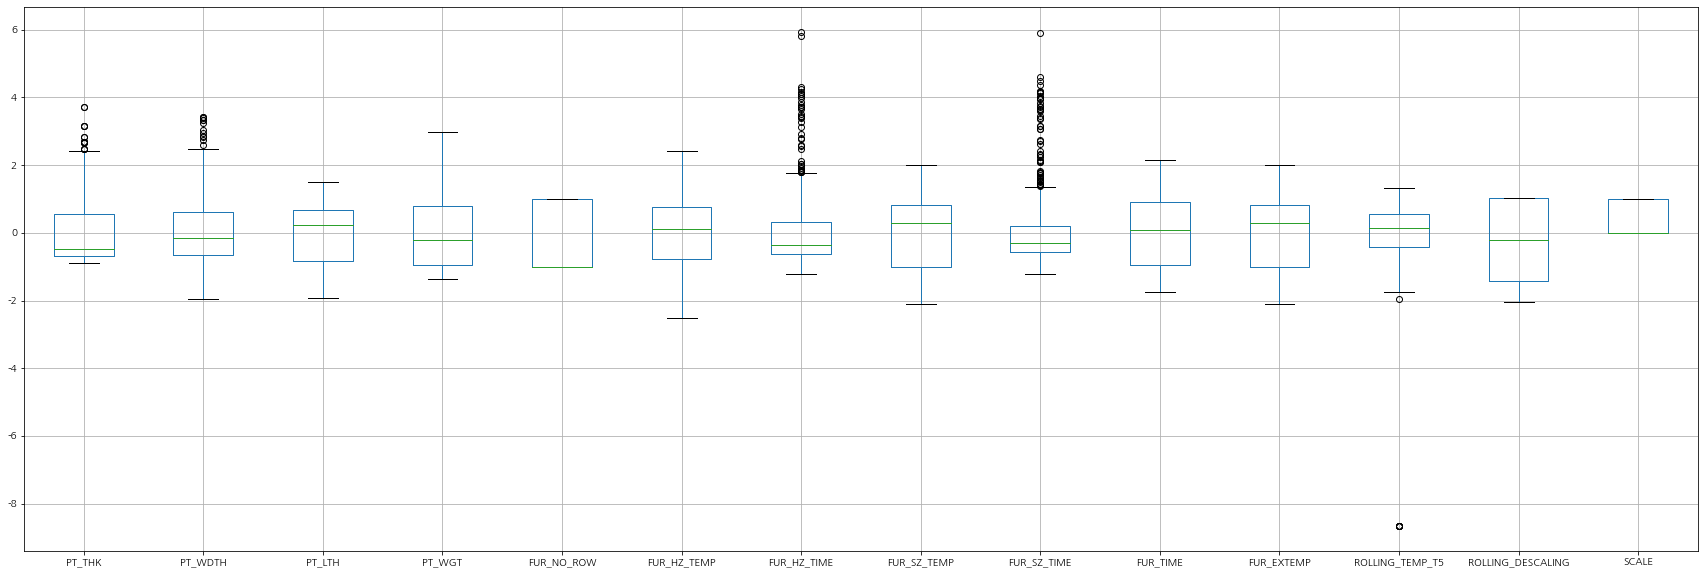

In [27]:
df_raw.boxplot(figsize=(30,10))

수치형 데이터의 이상치를 확인한 결과 ROLLING_TEMP_T5의 값에서 동떨어진 이상치를 확인할 수 있다.  
압연공정의 경우 일정한 온도에서 이루어지는 공정이기 때문에 이를 이상치라고 생각하고 제거한다.

In [28]:
df_raw = df_raw[df_raw.ROLLING_TEMP_T5 != min(df_raw['ROLLING_TEMP_T5'])]
df_raw

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR,SCALE
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,0.000734,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,0.028567,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.416748,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.453858,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-0.565186,-0.196930,BV-EH36-TM,T8,3호기,적용,1조,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.476916,1.493531,0.312308,-0.792904,-0.994460,0.799021,-0.439164,0.816269,-0.461669,-1.224987,0.816269,0.659429,-0.196930,NK-KA,C0,3호기,적용,2조,1
716,-0.741293,0.782392,1.006578,-0.935621,-0.994460,-0.256038,-0.731448,1.101013,-0.489145,-1.379312,1.101013,0.121341,1.036021,NV-A32,C0,2호기,적용,1조,0
717,-0.661875,1.224921,0.677679,-0.885084,1.005571,0.655149,-0.625163,0.759320,-0.049533,-1.180894,0.759320,0.130618,1.036021,NV-A32,C0,2호기,적용,4조,0
718,-0.714646,1.074191,1.043267,1.566994,1.005571,1.134722,-0.067166,0.759320,-0.928757,-1.269080,0.759320,0.056399,1.036021,LR-A,C0,3호기,적용,2조,0


<AxesSubplot:>

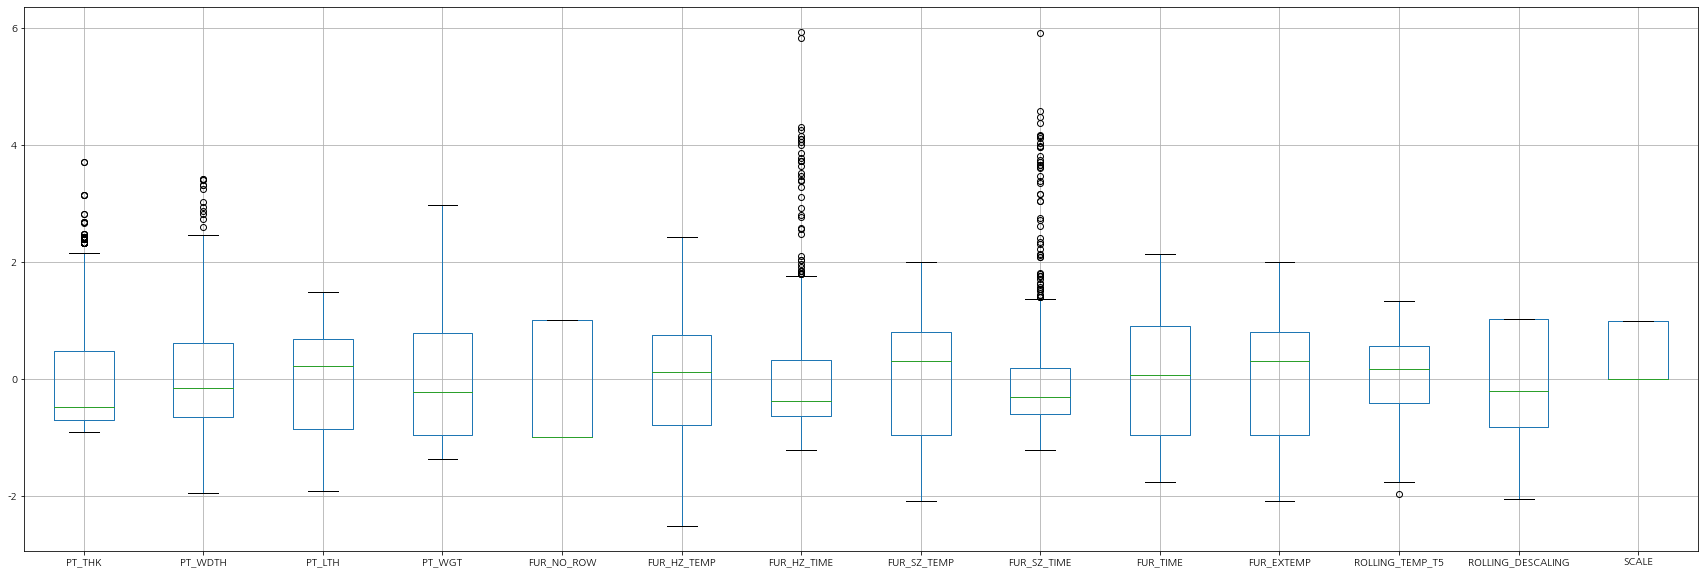

In [29]:
df_raw.boxplot(figsize=(30,10))

<AxesSubplot:>

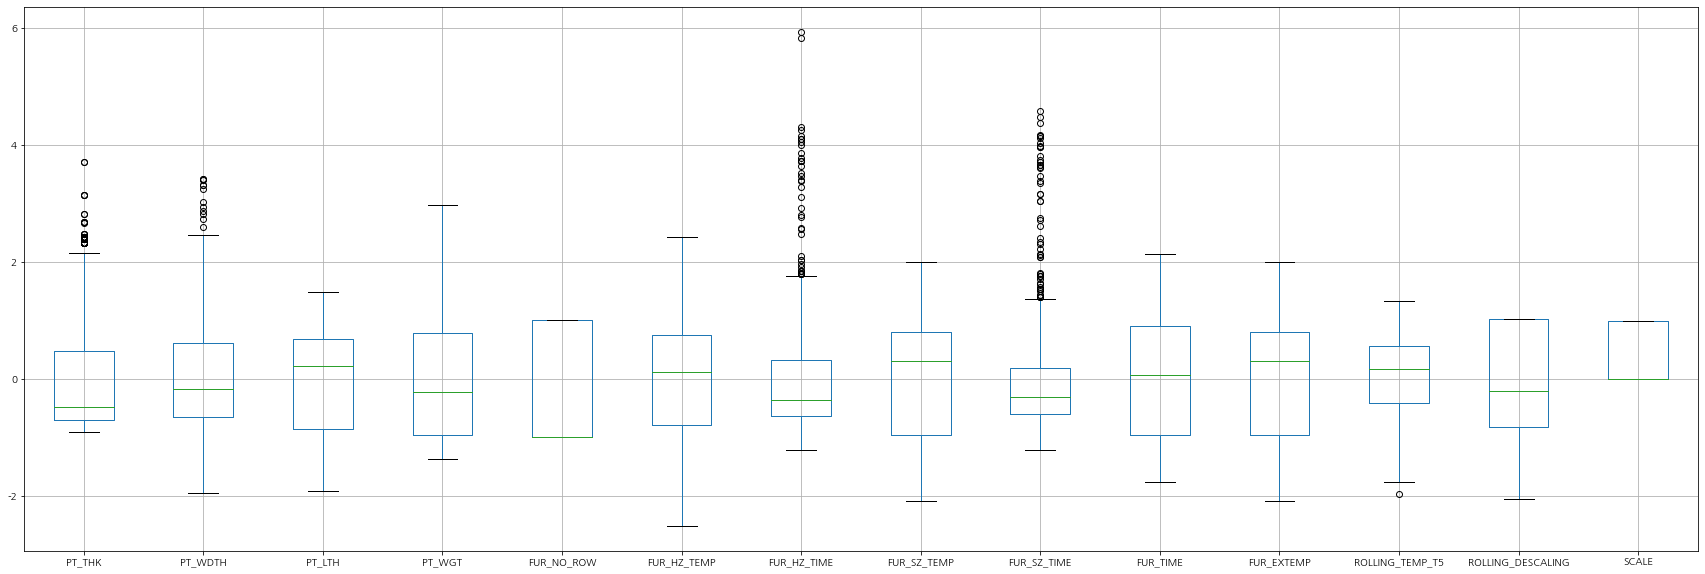

In [30]:
df_raw = df_raw[df_raw.FUR_SZ_TIME != max(df_raw['FUR_SZ_TIME'])]
df_raw.boxplot(figsize=(30,10))

<AxesSubplot:>

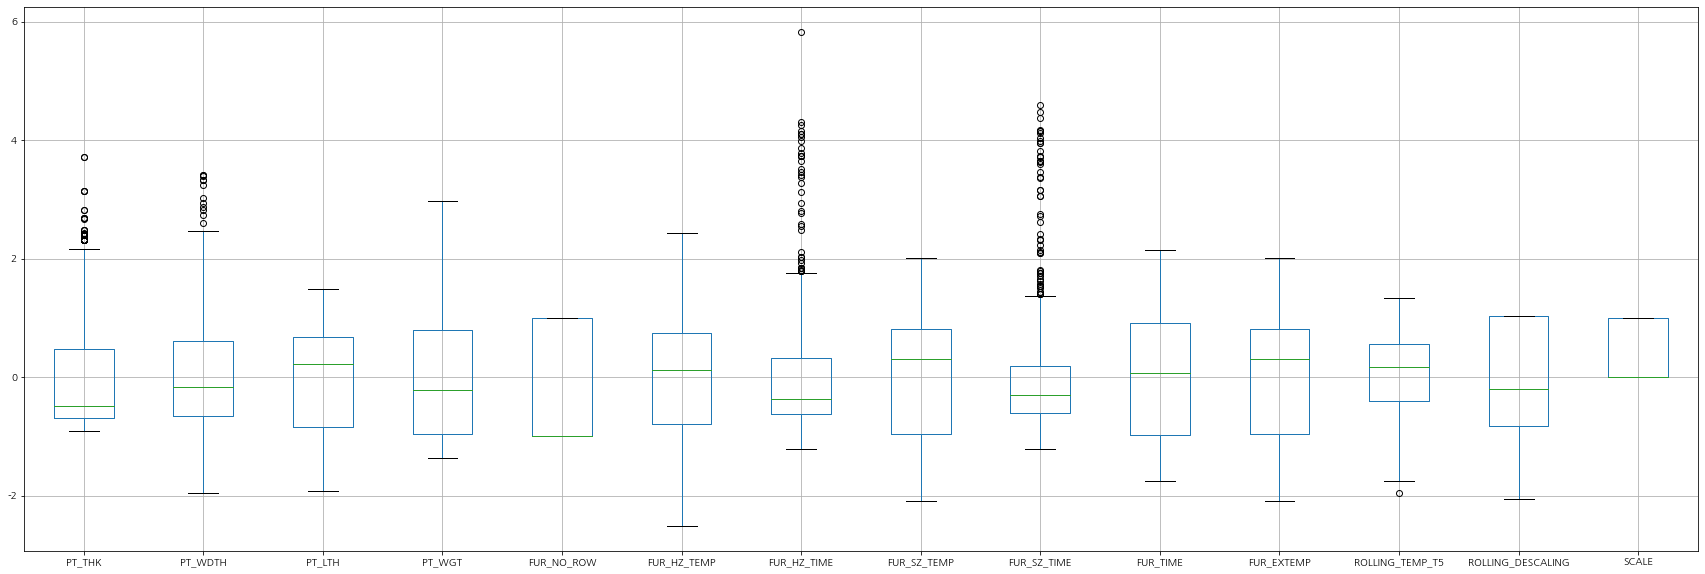

In [31]:
df_raw = df_raw[df_raw.FUR_HZ_TIME != max(df_raw['FUR_HZ_TIME'])]
df_raw.boxplot(figsize=(30,10))

<AxesSubplot:>

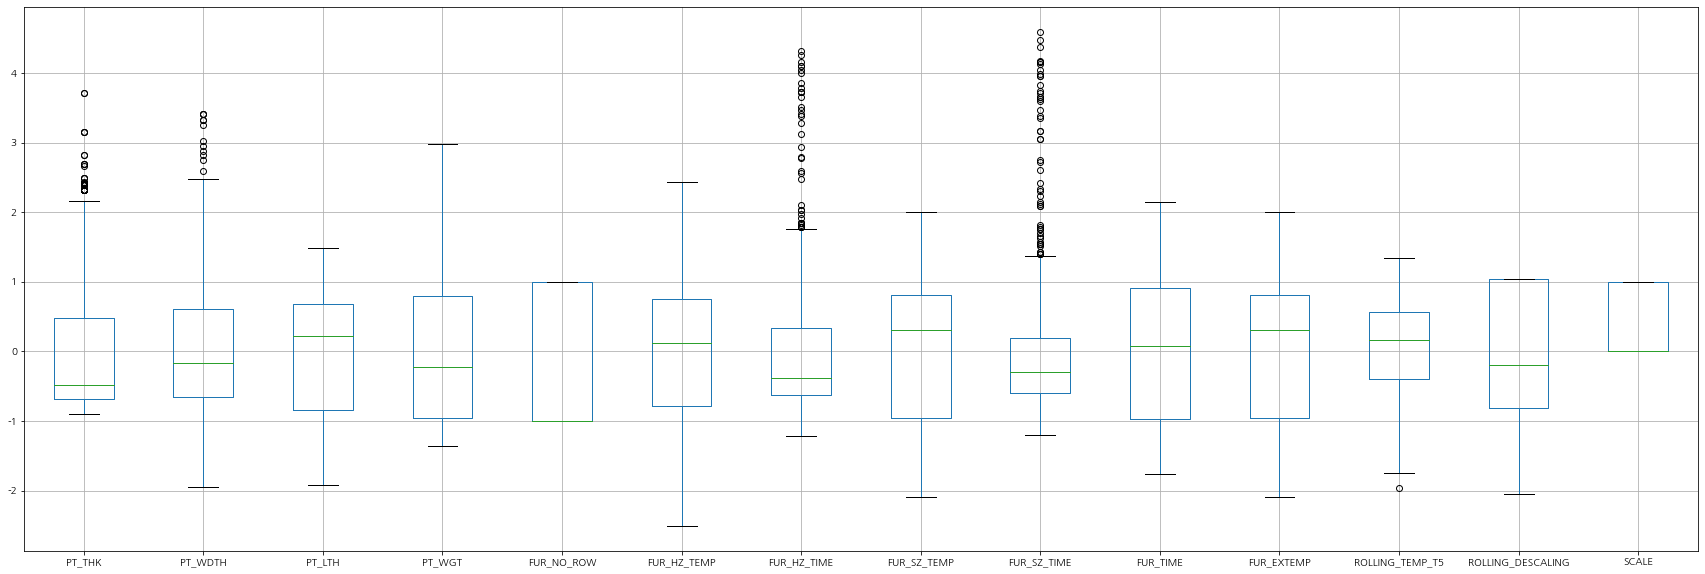

In [32]:
df_raw = df_raw[df_raw.FUR_HZ_TIME != max(df_raw['FUR_HZ_TIME'])]
df_raw.boxplot(figsize=(30,10))

## **EDA**
데이터 시각화를 통한 탐색적 자료 분석을 수행한다.

#### 1) 변수간의 상관 관계 확인 
이때 수행되는 것을 비 명목형 변수에 대해서만 상관관계만 수행된다.

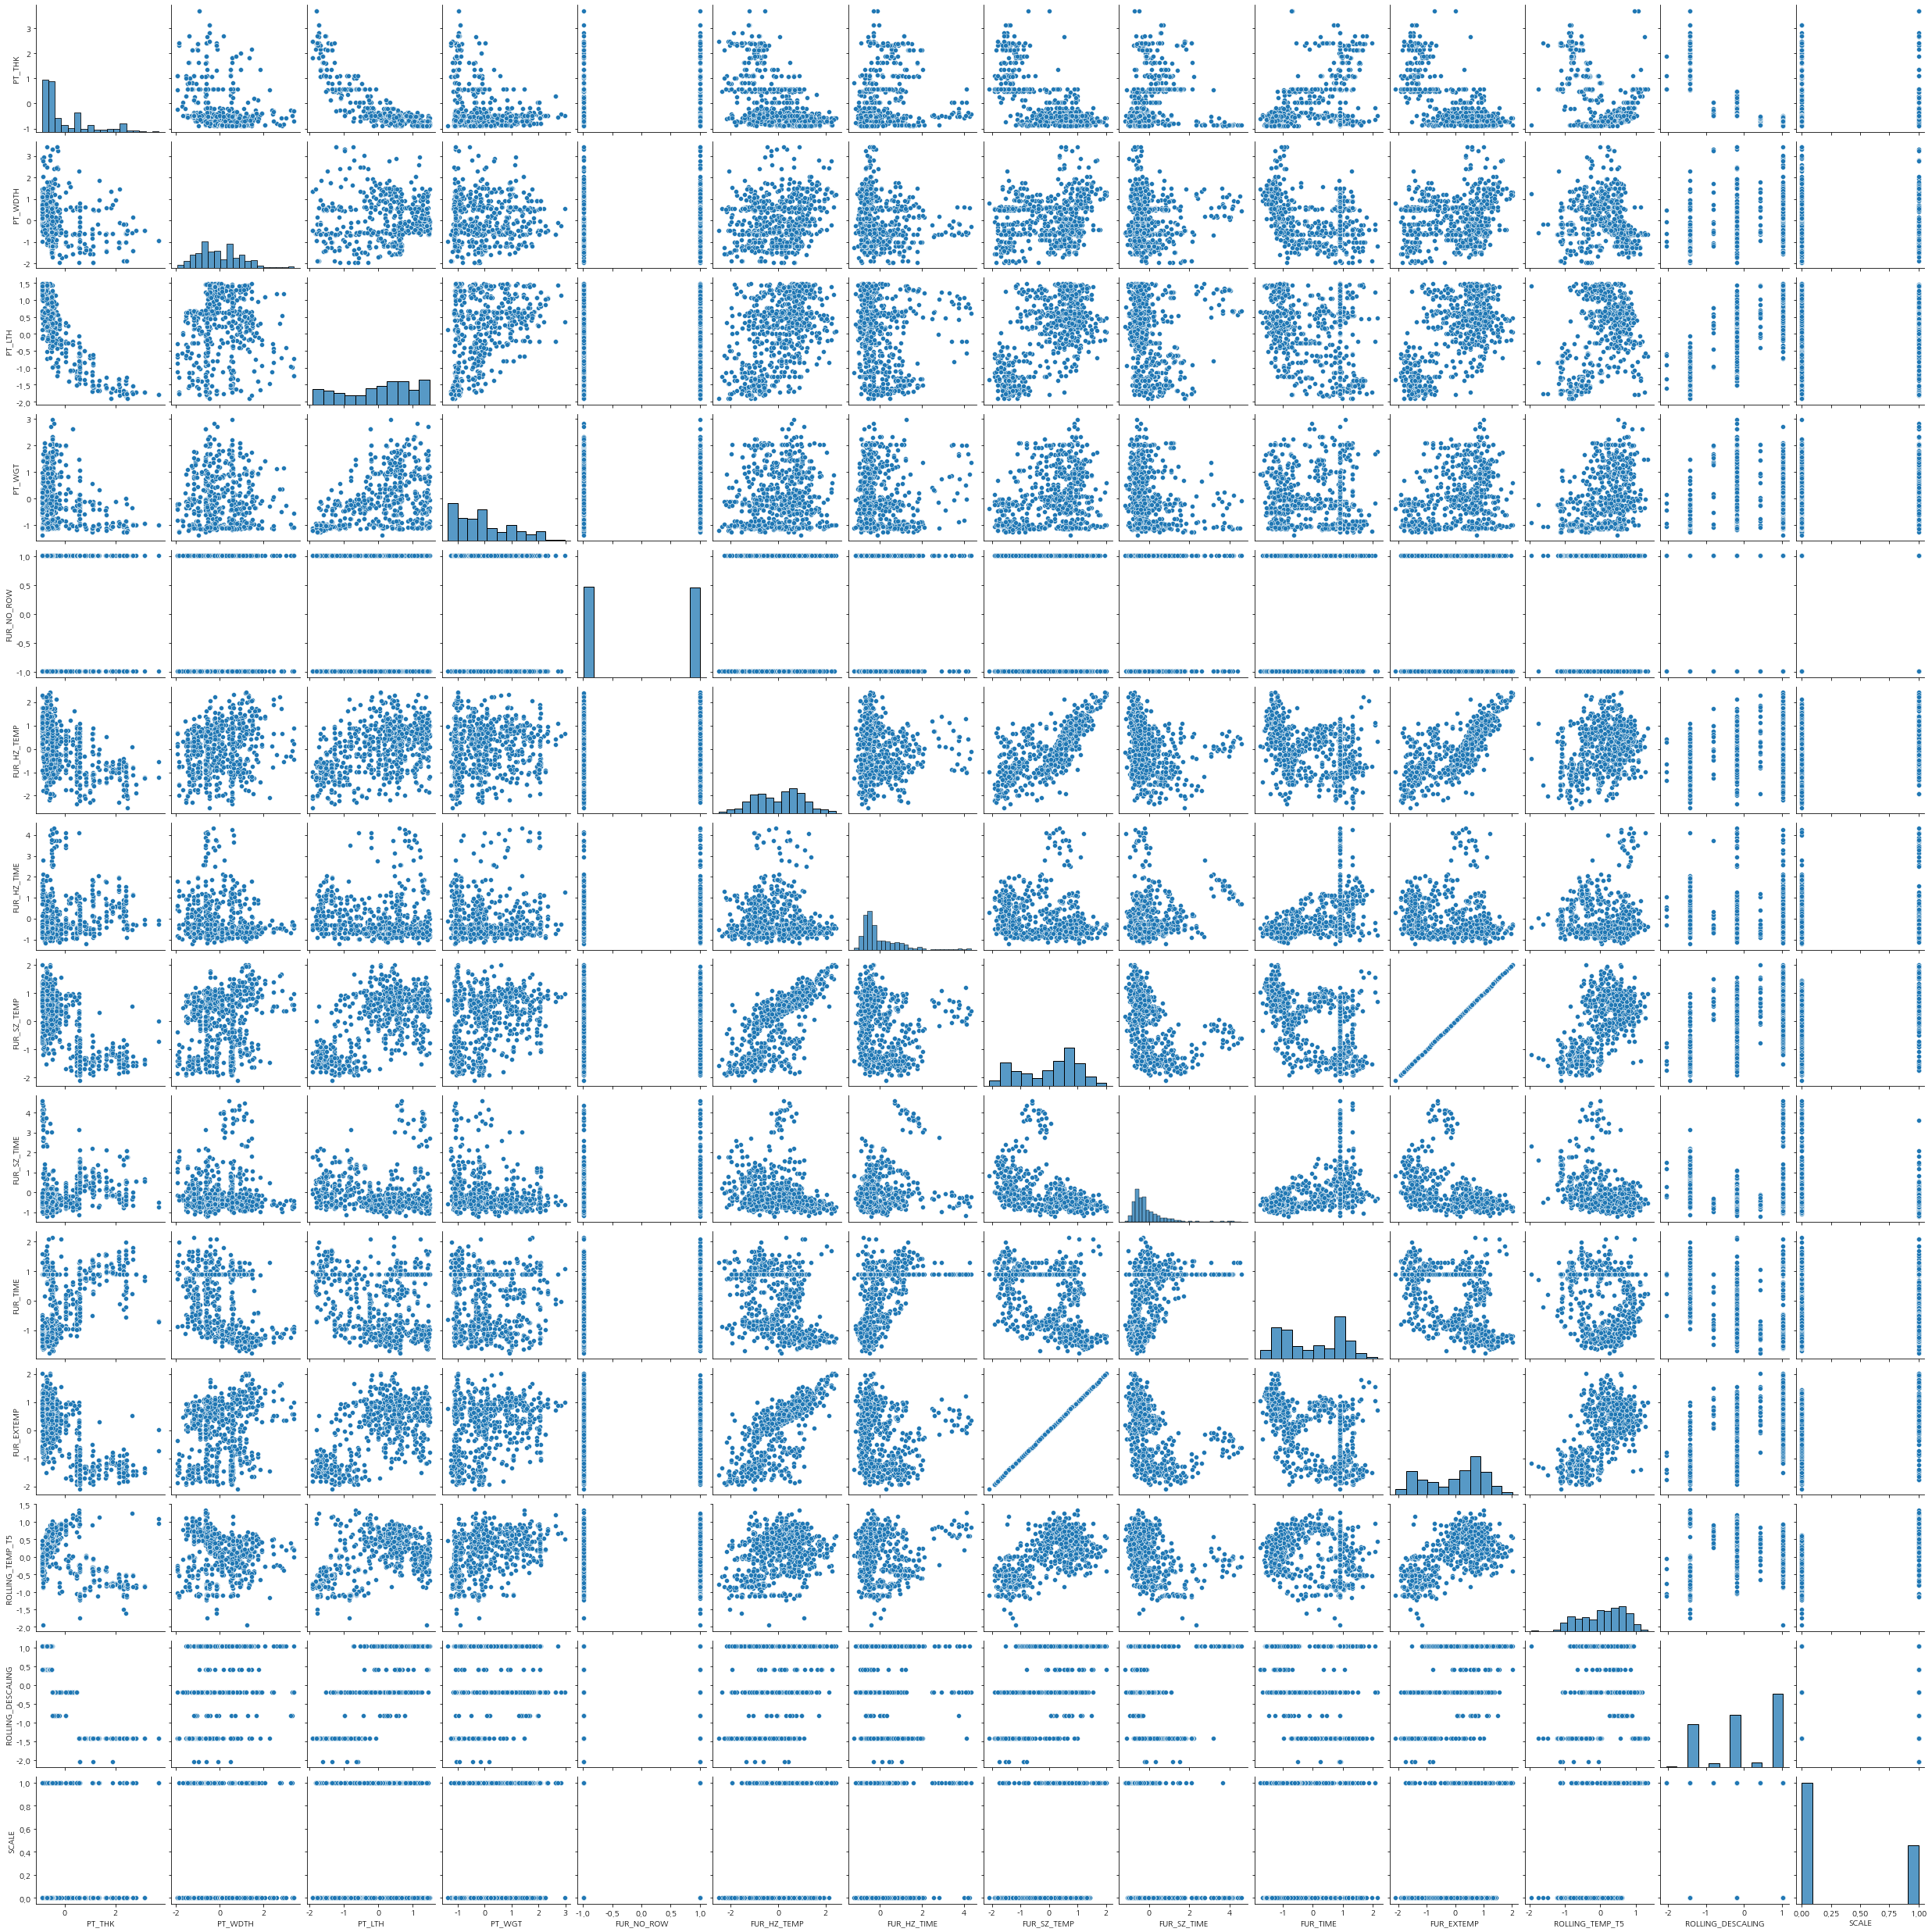

In [33]:
sns.pairplot(df_raw)

In [34]:
df_raw.corr().round(3)

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SCALE
PT_THK,1.000,-0.313,-0.862,-0.393,-0.004,-0.523,0.178,-0.695,0.127,0.410,-0.695,-0.504,-0.836,-0.123
PT_WDTH,-0.313,1.000,0.119,0.029,0.003,0.183,-0.133,0.232,0.010,-0.396,0.232,-0.111,0.341,-0.210
PT_LTH,-0.862,0.119,1.000,0.449,-0.019,0.474,-0.097,0.647,-0.085,-0.250,0.647,0.437,0.806,0.101
PT_WGT,-0.393,0.029,0.449,1.000,-0.022,0.151,0.008,0.358,-0.202,-0.055,0.358,0.421,0.233,0.221
FUR_NO_ROW,-0.004,0.003,-0.019,-0.022,1.000,0.003,0.002,0.009,0.041,0.019,0.009,-0.004,0.020,-0.024
FUR_HZ_TEMP,-0.523,0.183,0.474,0.151,0.003,1.000,-0.106,0.771,-0.226,-0.340,0.771,0.356,0.470,0.244
FUR_HZ_TIME,0.178,-0.133,-0.097,0.008,0.002,-0.106,1.000,-0.211,0.205,0.486,-0.211,0.001,-0.159,0.070
FUR_SZ_TEMP,-0.695,0.232,0.647,0.358,0.009,0.771,-0.211,1.000,-0.458,-0.471,1.000,0.662,0.648,0.374
FUR_SZ_TIME,0.127,0.010,-0.085,-0.202,0.041,-0.226,0.205,-0.458,1.000,0.454,-0.458,-0.380,-0.118,-0.244
FUR_TIME,0.410,-0.396,-0.250,-0.055,0.019,-0.340,0.486,-0.471,0.454,1.000,-0.471,-0.210,-0.366,-0.041


가열로 균열대 온도 (FUR_SZ_TEMP)와 압연 온도(FUR_EXTEMP)가 완벽히 비례하는 것을 확인할 수 있다.

상관관계는 -1~1의 분포를 지니는데 여기서 0.5가 넘어가는 변수들간의 상관관계가 빈출되는 것은 충분히 다중공선성 발생을 의심할 수 있다.

따라서 강한 상관관계를 나타내기 때문에 다중 공산성을 확인해야 한다.

##### 정제된 데이터로 다시 설명변수와 목표변수 나누기


In [35]:
df_raw = df_raw.reset_index(drop=True)
df_raw_x = df_raw.drop(["SCALE"], axis = 1, inplace = False) # 설명 변수 
df_raw_y = df_raw["SCALE"] # 목표 변수

In [36]:
df_numeric = df_raw_x.select_dtypes(exclude = 'object')
num_cols = df_numeric.columns
num_cols

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'ROLLING_DESCALING'],
      dtype='object')

In [37]:
df_object = df_raw_x.select_dtypes(include = 'object')
obj_cols = df_object.columns
obj_cols

Index(['SPEC', 'STEEL_KIND', 'FUR_NO', 'HSB', 'WORK_GR'], dtype='object')

### 다중공산성
Vif가 10이상이면 회귀분석의 기본 가정인 ‘모든 독립변수는 서로 독립이다 ‘가 깨지기 때문에 회귀분석을 돌리지 않는다.

VIF가 10이상인 변수를 모두 지운다.

In [38]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
vif["features"] = df_numeric.columns
vif

/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,6.957627,PT_THK
1,1.838909,PT_WDTH
2,6.317002,PT_LTH
3,1.588795,PT_WGT
4,1.010626,FUR_NO_ROW
5,3.167271,FUR_HZ_TEMP
6,1.406385,FUR_HZ_TIME
7,inf,FUR_SZ_TEMP
8,1.878655,FUR_SZ_TIME
9,2.220025,FUR_TIME


vif가 높은 변수가 하나씩 줄이면 다른 변수들의 vif에도 영향을 미친다. 

그래서 변수들을 한 번에 다 제거하기보다는 하나씩 제거하면서 확인해야 한다.

우선 다중 공산성이 가장 높은 가열로 균열대 온도 (FUR_SZ_TEMP)와 압연 온도(FUR_EXTEMP)를 각각 제거해보고 다른 변수의 vif를 살펴본다.

##### 1) 가열로 균열대 온도 (FUR_SZ_TEMP) 제거시 vif

In [39]:
df_numeric_sz = df_numeric.drop(["FUR_SZ_TEMP"], axis = 1, inplace = False)

vif_SZ = pd.DataFrame()
vif_SZ["VIF Factor"] = [variance_inflation_factor(df_numeric_sz.values, i) for i in range(df_numeric_sz.shape[1])]
vif_SZ["features"] = df_numeric_sz.columns
vif_SZ

,VIF Factor,features
0,6.957627,PT_THK
1,1.838909,PT_WDTH
2,6.317002,PT_LTH
3,1.588795,PT_WGT
4,1.010626,FUR_NO_ROW
5,3.167271,FUR_HZ_TEMP
6,1.406385,FUR_HZ_TIME
7,1.878655,FUR_SZ_TIME
8,2.220025,FUR_TIME
9,7.902976,FUR_EXTEMP


##### 2) 압연 온도(FUR_EXTEMP) 제거시 vif

In [40]:
df_numeric_EXTEMP = df_numeric.drop(["FUR_EXTEMP"], axis = 1, inplace = False)

vif_EXTEMP = pd.DataFrame()
vif_EXTEMP["VIF Factor"] = [variance_inflation_factor(df_numeric_EXTEMP.values, i) for i in range(df_numeric_EXTEMP.shape[1])]
vif_EXTEMP["features"] = df_numeric_EXTEMP.columns
vif_EXTEMP

,VIF Factor,features
0,6.957627,PT_THK
1,1.838909,PT_WDTH
2,6.317002,PT_LTH
3,1.588795,PT_WGT
4,1.010626,FUR_NO_ROW
5,3.167271,FUR_HZ_TEMP
6,1.406385,FUR_HZ_TIME
7,7.902976,FUR_SZ_TEMP
8,1.878655,FUR_SZ_TIME
9,2.220025,FUR_TIME


상관관계가 높은 가열로 균열대 온도 (FUR_SZ_TEMP)와 압연 온도(FUR_EXTEMP)를 각각 제거했을때 모든 변수의 VIF는 같고 줄어든 것을 확인할 수 있다.

따라서 두 변수 중 아무 변수나 삭제 할 수 있다는 것을 의미하고 여기서는 가열로 균열대 온도 (FUR_SZ_TEMP)를 제거한다.  
vif가 더이상 10보다 큰 수가 없기 때문에 더이상 변수를 제거하지 않는다.

In [41]:
df_raw.drop(["FUR_SZ_TEMP"], axis = 1, inplace = True)
df_raw_x.drop(["FUR_SZ_TEMP"], axis = 1, inplace = True)
df_raw.columns

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'ROLLING_DESCALING', 'SPEC', 'STEEL_KIND', 'FUR_NO',
       'HSB', 'WORK_GR', 'SCALE'],
      dtype='object')

In [42]:
df_raw_x.columns

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'ROLLING_DESCALING', 'SPEC', 'STEEL_KIND', 'FUR_NO',
       'HSB', 'WORK_GR'],
      dtype='object')

#### 2) 제품 규격(SPEC)별 EDA
앞서 제품 규격이 66개의 범주로 구성되어 있다는 것을 확인했다.
이에 EDA를 살펴보아 의미있는 결과를 추론하기 힘들기 때문에 후에 군집분석을 수행하고 다시 EDA를 살펴볼 필요가 있다.
  
**포스코 제품 규격** : http://product.posco.com/homepage/product/kor/jsp/process/s91p2000230p.jsp

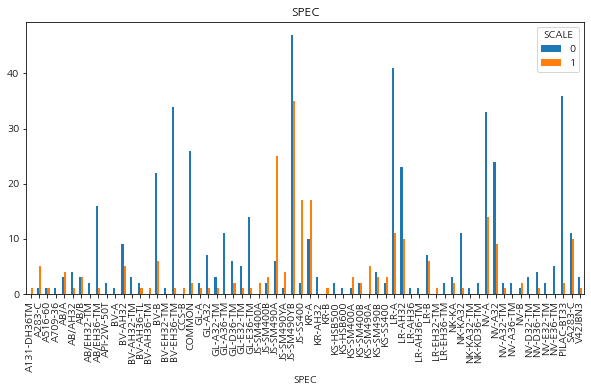

In [43]:
df_SPEC_eda = df_raw.groupby(["SPEC",'SCALE'])['SCALE'].count().unstack('SCALE')
df_SPEC_eda.plot(kind='bar', figsize=(10,5))
plt.title('SPEC')
plt.show()

<AxesSubplot:ylabel='SPEC'>

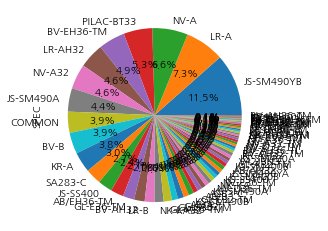

In [44]:
df_raw['SPEC'].value_counts().plot.pie(y = 'SPEC', autopct = '%.1f%%')

In [45]:
df_raw['SPEC'].value_counts()

JS-SM490YB    82
LR-A          52
NV-A          47
PILAC-BT33    38
BV-EH36-TM    35
              ..
KR-B           1
BV-A           1
CCS-B          1
KS-HSB600      1
BV-AH36-TM     1
Name: SPEC, Length: 66, dtype: int64

In [46]:
df_raw['SCALE'].value_counts()

0    480
1    231
Name: SCALE, dtype: int64

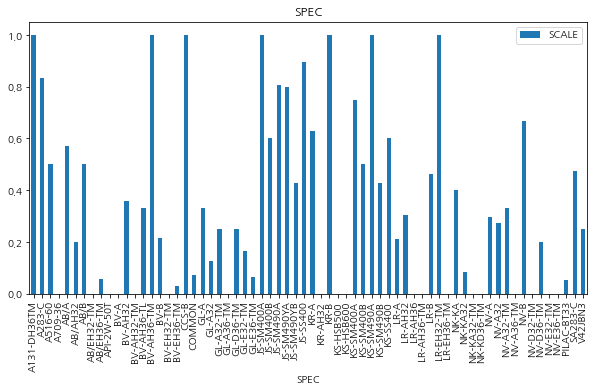

In [47]:
df_SPEC_eda_avg = df_raw.groupby(["SPEC"], as_index=False)['SCALE'].mean()
df_SPEC_eda_avg.plot(x = 'SPEC', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('SPEC')
plt.show()

In [48]:
df_raw['spec_name'] = df_raw.SPEC.str.split("-").str[0]
df_raw['spec_name'].value_counts()

JS         144
LR         103
NV         103
BV          86
GL          55
PILAC       38
KR          31
COMMON      28
KS          28
SA283       21
NK          20
AB/EH36     17
AB/A         7
AB/B         6
A283         6
AB/AH32      5
V42JBN3      4
API          2
A516         2
AB/EH32      2
A131         1
CCS          1
A709         1
Name: spec_name, dtype: int64

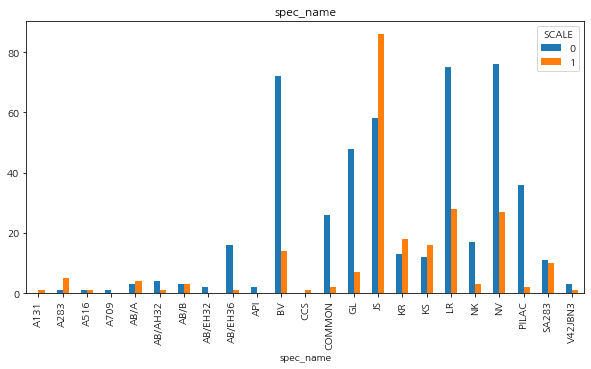

In [49]:
df_spec_name_eda = df_raw.groupby(["spec_name",'SCALE'])['SCALE'].count().unstack('SCALE')
df_spec_name_eda.plot(kind='bar', figsize=(10,5))
plt.title('spec_name')
plt.show()

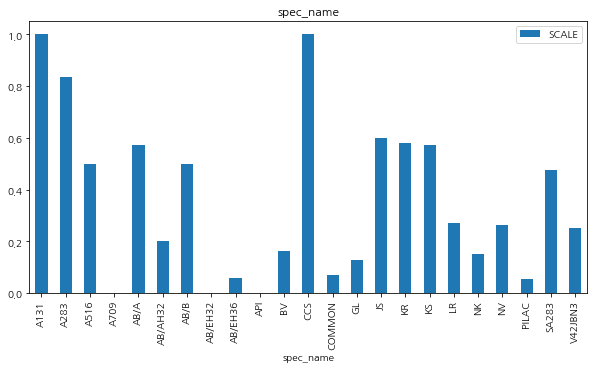

In [50]:
df_spec_name_eda_avg = df_raw.groupby(["spec_name"], as_index=False)['SCALE'].mean()
df_spec_name_eda_avg.plot(x = 'spec_name', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('spec_name')
plt.show()

제품 규격(SPEC)별 EDA를 살펴본 결과 -를 기준으로 같은 제품규격을 나타내는 것으로 확인되었다.   
따라서 이를 나누고 EDA를 살펴본 결과 A131, A283, AB/A, CCS, JS, KR, KS, SA283인 경우 scale 불량률이 높은 것을 알 수 있었다.

#### 3) 강종(STEEL_KIND)별 EDA

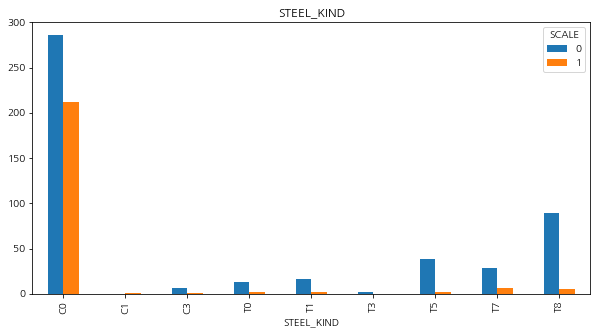

In [51]:
df_STEEL_KIND_eda = df_raw.groupby(["STEEL_KIND",'SCALE'])['SCALE'].count().unstack('SCALE')
df_STEEL_KIND_eda.plot(kind='bar', figsize=(10,5))
plt.title('STEEL_KIND')
plt.show()

<AxesSubplot:ylabel='STEEL_KIND'>

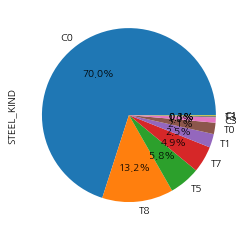

In [52]:
df_raw['STEEL_KIND'].value_counts().plot.pie(y = 'STEEL_KIND', autopct = '%.1f%%')

In [53]:
df_raw['STEEL_KIND'].value_counts()

C0    498
T8     94
T5     41
T7     35
T1     18
T0     15
C3      7
T3      2
C1      1
Name: STEEL_KIND, dtype: int64

강종(STEEL_KIND)이 co일때 가장 많은 scale 불량이 발생한 것을 알 수 있다.  
다만 양품일때 비율 역시 가장 높은 것으로 보아 가장 많은 것을 알 수 있다.  
이는 co가 전체 강종 중 69.9%를 차지하는 비율이기 때문인 것으로 보여진다.

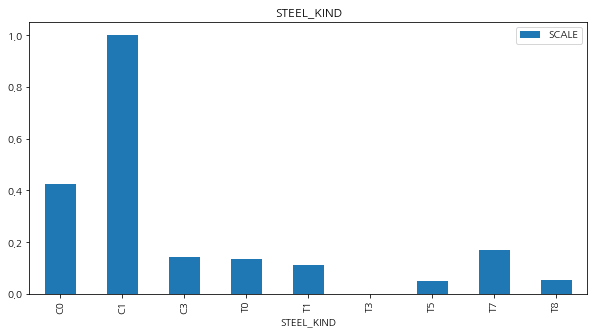

In [54]:
df_STEEL_KIND_eda_avg = df_raw.groupby(["STEEL_KIND"], as_index=False)['SCALE'].mean()
df_STEEL_KIND_eda_avg.plot(x = 'STEEL_KIND', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('STEEL_KIND')
plt.show()

강종(STEEL_KIND)의 개수에 비례해 발생한 scale을 본다면 c1일때 100% 불량이 발생한다고 결론이 도출된다.
하지만 위에 value_counts() 결론에서 c1은 1개였기 때문에 이는 의미있는 결론이 아니라고 판단된다.  
1개의 표본만을 가지는 c1을 제외하고 강종(STEEL_KIND)이 c0일때 scale 불량 발생 인자일 가능성이 높다는 결론을 도출할 수 있다.

#### 4) 가열호기(FUR_NO)별 EDA

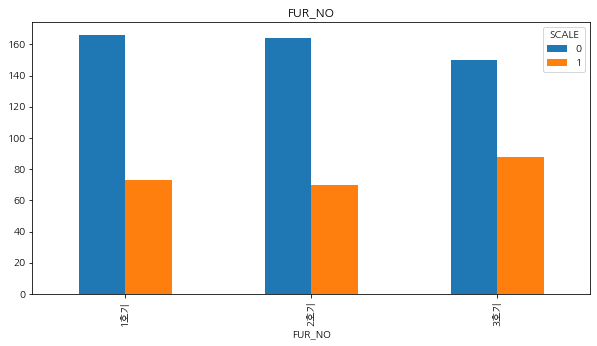

In [55]:
df_FUR_NO_eda = df_raw.groupby(["FUR_NO",'SCALE'])['SCALE'].count().unstack('SCALE')
df_FUR_NO_eda.plot(kind='bar', figsize=(10,5))
plt.title('FUR_NO')
plt.show()

<AxesSubplot:ylabel='FUR_NO'>

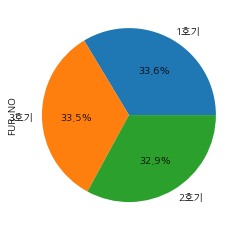

In [56]:
df_raw['FUR_NO'].value_counts().plot.pie(y = 'FUR_NO', autopct = '%.1f%%')

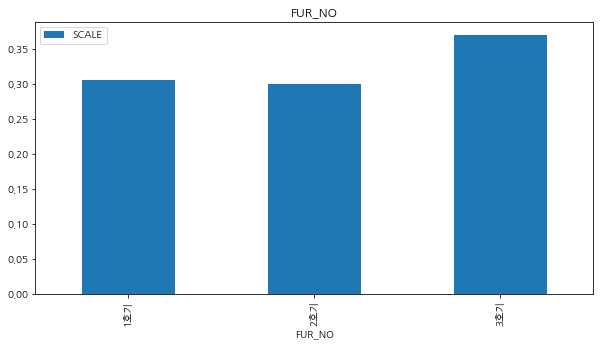

In [57]:
df_FUR_NO_eda_avg = df_raw.groupby(["FUR_NO"], as_index=False)['SCALE'].mean()
df_FUR_NO_eda_avg.plot(x = 'FUR_NO', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('FUR_NO')
plt.show()

가열호기(FUR_NO)의 경우 전체 개수가 비슷한 것을 확인할 수 있다.  
하지만 각 가열호기별 scale 분량률을 확인한 결과 3호기일때 scale 불량 발생률이 높다는 결론을 도출할 수 있다.

#### 5) HSB 적용(1 - 적용, 0 - 미적용)별 EDA

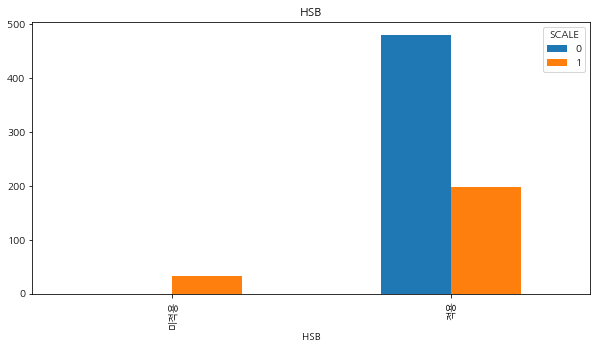

In [58]:
df_HSB_eda = df_raw.groupby(["HSB",'SCALE'])['SCALE'].count().unstack('SCALE')
df_HSB_eda.plot(kind='bar', figsize=(10,5))
plt.title('HSB')
plt.show()

<AxesSubplot:ylabel='HSB'>

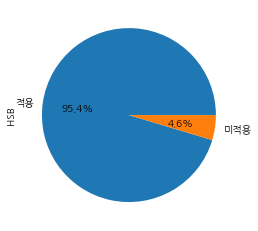

In [59]:
df_raw['HSB'].value_counts().plot.pie(y = 'HSB', autopct = '%.1f%%')

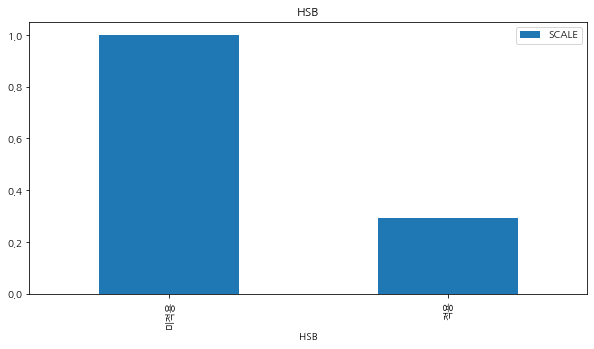

In [60]:
df_HSB_eda_avg = df_raw.groupby(["HSB"], as_index=False)['SCALE'].mean()
df_HSB_eda_avg.plot(x = 'HSB', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('HSB')
plt.show()

각각 HSB 적용 미적용에 대해 불량률은 상대적으로 적용일때가 많아 보이지만 이는 적용일때 개수가 월등히 많아서 인것으로 추정된다.  
따라서 개수대비 평균 값을 계산해본 결과 미적용인 경우 반드시 scale 불량이 나타난다는 결론을 도출할 수 있다.

#### 6) 작업조 (WORK_GR)별 EDA

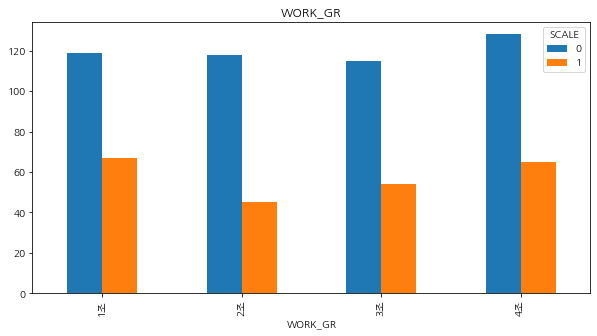

In [61]:
df_WORK_GR_eda = df_raw.groupby(["WORK_GR",'SCALE'])['SCALE'].count().unstack('SCALE')
df_WORK_GR_eda.plot(kind='bar', figsize=(10,5))
plt.title('WORK_GR')
plt.show()

<AxesSubplot:ylabel='WORK_GR'>

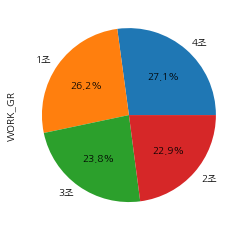

In [62]:
df_raw['WORK_GR'].value_counts().plot.pie(y = 'WORK_GR', autopct = '%.1f%%')

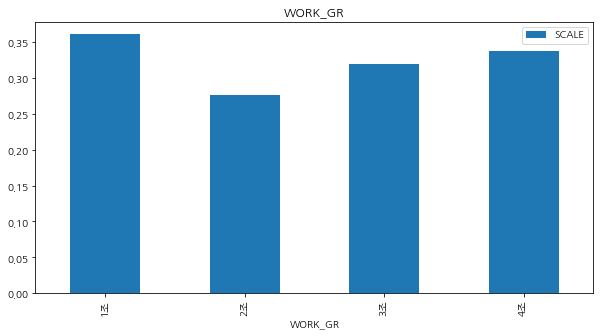

In [63]:
df_WORK_GR_eda_avg = df_raw.groupby(["WORK_GR"], as_index=False)['SCALE'].mean()
df_WORK_GR_eda_avg.plot(x = 'WORK_GR', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('WORK_GR')
plt.show()

작업조 (WORK_GR)별 EDA를 살펴보았을때 월등히는 아니지만 1조일때 scale불량률이 높은 것을 알 수 있다.

## 군집분석
데이터 확인때 66개의 군집으로 이루어진 'SPEC'변수를 가지고 군집분석을 수행하여 이를 dummy변수로 만들기 전 변수를 줄이는 과정을 수행한다.

In [64]:
df_spec = df_raw.groupby(['SPEC']).mean()
df_spec

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SCALE
SPEC,,,,,,,,,,,,,
A131-DH36TM,2.164763,1.474206,-1.819855,-0.942090,1.005571,-1.311098,0.092261,1.818820,0.913519,-1.632537,-0.695070,-1.429880,1.000000
A283-C,-0.290128,-0.398652,-0.146257,0.937903,0.005556,0.543249,-0.505592,-0.292235,0.189661,0.664405,0.742926,0.111308,0.833333
A516-60,-0.860419,2.055871,1.092041,1.431149,0.005556,1.350530,-0.425878,-0.338028,-1.202940,1.385758,-0.277587,1.036021,0.500000
A709-36,-0.158201,-0.013774,-0.391008,-0.328363,-0.994460,-0.256038,-0.678305,-0.544097,-0.806104,0.246779,0.548100,-0.196930,0.000000
AB/A,-0.567977,1.094896,0.359252,0.458346,1.005571,0.271491,0.536381,0.688388,-0.100618,0.596608,0.212789,0.595682,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NV-E32-TM,-0.833772,-0.641818,1.460415,0.602335,0.005556,-0.303996,-0.890876,-0.145698,-1.015545,-0.180338,-0.402832,1.036021,0.000000
NV-E36-TM,1.222829,0.683065,-1.391194,-0.947427,0.205559,-0.956214,0.533344,-0.247358,0.362358,-1.268064,-0.659816,-0.936700,0.000000
PILAC-BT33,1.754750,-0.943075,-1.392547,-0.837791,0.058188,-0.534948,1.113157,0.367665,1.426970,-1.467685,-0.448242,-1.429880,0.052632


In [65]:
scaler = StandardScaler()
df_raw_scaled = scaler.fit_transform(df_spec)
df_raw_scaled[:5]

array([[ 2.15178677,  1.7294462 , -1.75140623, -1.2552836 ,  1.96131588,
        -1.6744092 ,  0.19339845,  2.08762838,  1.27235742, -1.59151189,
        -0.99182849, -1.30898845,  1.95694789],
       [-0.39131672, -0.47644007, -0.01812937,  1.35947464,  0.00717104,
         0.79957841, -0.72017796, -0.5187538 ,  0.31714369,  0.90052616,
         1.35907953,  0.25941338,  1.46429487],
       [-0.98210047,  2.41454175,  1.26432539,  2.04549724,  0.00717104,
         1.87661611, -0.59836777, -0.57529137, -1.52055177,  1.68314968,
        -0.30930681,  1.20045448,  0.47898884],
       [-0.25464892, -0.02312381, -0.27160751, -0.40169155, -1.9469738 ,
        -0.26679556, -0.98410003, -0.82971045, -0.99688129,  0.44742833,
         1.04056941, -0.05426699, -0.99897022],
       [-0.6791503 ,  1.28268717,  0.50540593,  0.69249038,  1.96131588,
         0.43701126,  0.8720552 ,  0.69195797, -0.06591156,  0.82697132,
         0.49238533,  0.75233967,  0.69012585]])

In [66]:
df_raw_scaled_y = df_raw_scaled[:, 0]
df_raw_scaled_x = df_raw_scaled[:, 1::]

Text(0, 0.5, 'sample index')

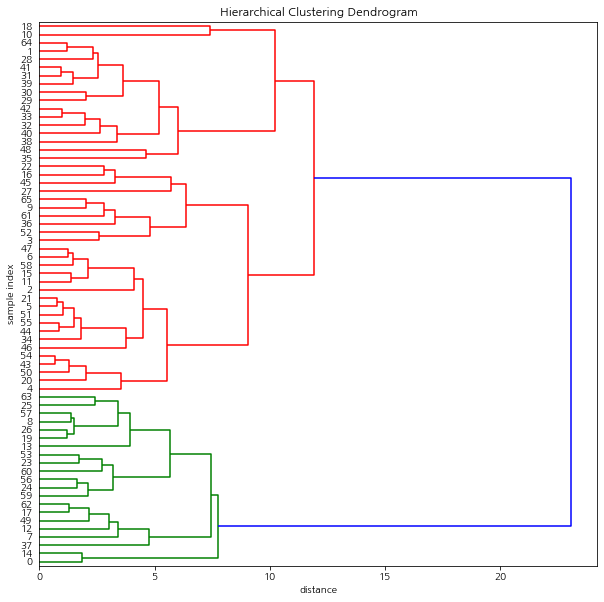

In [67]:
Z_ward = linkage(df_raw_scaled_x, method='ward', metric='euclidean')
Z_average = linkage(df_raw_scaled_x, method='average', metric='euclidean')
Z_Minkowski = linkage(df_raw_scaled_x, method='average', metric='minkowski')

plt.figure(figsize=(10,10))
ax = plt.subplot(111)

dendrogram(Z_ward, leaf_font_size=10, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
plt.ylabel('sample index')

In [68]:
cluster_hierarchical = fcluster(Z = Z_ward, t = 8, criterion='distance')
df_spec['clusterHierarchical'] = cluster_hierarchical
df_spec['clusterHierarchical'].unique()

array([1, 4, 2, 3, 5], dtype=int32)

군집분석시 5개의 분집으로 나눠 5개의 그룹으로 바꿔진 것을 알게되었다.

그룹으로 나눠진 군집을 원래 데이터에 값에 추가하기 위해 merge를 사용한다.

In [69]:
df_spec.reset_index(drop = False, inplace = True)
df_raw_cluster_spec = df_spec[['SPEC', 'clusterHierarchical']]

In [70]:
mer = pd.merge(df_raw, df_raw_cluster_spec, how='left', on = 'SPEC')
mer

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR,SCALE,spec_name,clusterHierarchical
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.544097,-0.409268,-0.949149,0.000734,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0,AB/EH32,1
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.708951,-0.387221,-0.835252,0.028567,-0.196930,AB/EH32-TM,T1,1호기,적용,2조,0,AB/EH32,1
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-0.654000,-0.409268,-1.632537,-0.416748,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0,NV,1
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-0.296815,0.340311,-1.290843,-0.453858,-0.196930,NV-E36-TM,T8,2호기,적용,3조,0,NV,1
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-0.846330,0.296219,-1.233894,-0.565186,-0.196930,BV-EH36-TM,T8,3호기,적용,1조,0,BV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,-0.476916,1.493531,0.312308,-0.792904,-0.994460,0.799021,-0.439164,-0.461669,-1.224987,0.816269,0.659429,-0.196930,NK-KA,C0,3호기,적용,2조,1,NK,2
707,-0.741293,0.782392,1.006578,-0.935621,-0.994460,-0.256038,-0.731448,-0.489145,-1.379312,1.101013,0.121341,1.036021,NV-A32,C0,2호기,적용,1조,0,NV,2
708,-0.661875,1.224921,0.677679,-0.885084,1.005571,0.655149,-0.625163,-0.049533,-1.180894,0.759320,0.130618,1.036021,NV-A32,C0,2호기,적용,4조,0,NV,2
709,-0.714646,1.074191,1.043267,1.566994,1.005571,1.134722,-0.067166,-0.928757,-1.269080,0.759320,0.056399,1.036021,LR-A,C0,3호기,적용,2조,0,LR,2


In [71]:
mer.drop(["SPEC"], axis = 1, inplace = True)
mer

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,STEEL_KIND,FUR_NO,HSB,WORK_GR,SCALE,spec_name,clusterHierarchical
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.544097,-0.409268,-0.949149,0.000734,-0.196930,T1,1호기,적용,2조,0,AB/EH32,1
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.708951,-0.387221,-0.835252,0.028567,-0.196930,T1,1호기,적용,2조,0,AB/EH32,1
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-0.654000,-0.409268,-1.632537,-0.416748,-0.196930,T8,2호기,적용,3조,0,NV,1
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-0.296815,0.340311,-1.290843,-0.453858,-0.196930,T8,2호기,적용,3조,0,NV,1
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-0.846330,0.296219,-1.233894,-0.565186,-0.196930,T8,3호기,적용,1조,0,BV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,-0.476916,1.493531,0.312308,-0.792904,-0.994460,0.799021,-0.439164,-0.461669,-1.224987,0.816269,0.659429,-0.196930,C0,3호기,적용,2조,1,NK,2
707,-0.741293,0.782392,1.006578,-0.935621,-0.994460,-0.256038,-0.731448,-0.489145,-1.379312,1.101013,0.121341,1.036021,C0,2호기,적용,1조,0,NV,2
708,-0.661875,1.224921,0.677679,-0.885084,1.005571,0.655149,-0.625163,-0.049533,-1.180894,0.759320,0.130618,1.036021,C0,2호기,적용,4조,0,NV,2
709,-0.714646,1.074191,1.043267,1.566994,1.005571,1.134722,-0.067166,-0.928757,-1.269080,0.759320,0.056399,1.036021,C0,3호기,적용,2조,0,LR,2


In [72]:
distmer = mer.select_dtypes("object").columns
distmer

Index(['STEEL_KIND', 'FUR_NO', 'HSB', 'WORK_GR', 'spec_name'], dtype='object')

In [73]:
mer.groupby('SCALE')

##### 1) 새로운 군집으로 분류한 SPEC 기준 EDA 수행

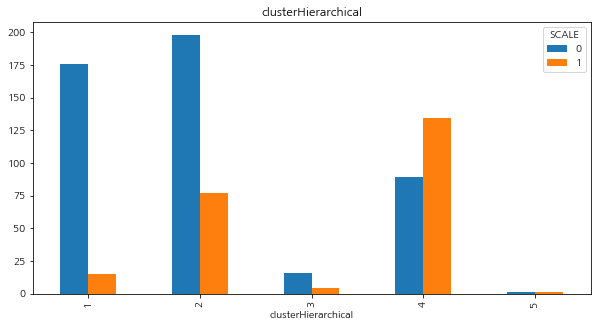

<AxesSubplot:ylabel='clusterHierarchical'>

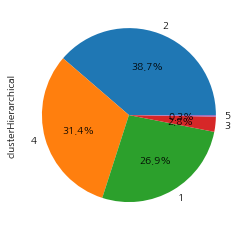

In [74]:
df_cluster_eda = mer.groupby(["clusterHierarchical",'SCALE'])['SCALE'].count().unstack('SCALE')
df_cluster_eda.plot(kind='bar', figsize=(10,5))
plt.title('clusterHierarchical')
plt.show()

mer['clusterHierarchical'].value_counts().plot.pie(y = 'clusterHierarchical', autopct = '%.1f%%')

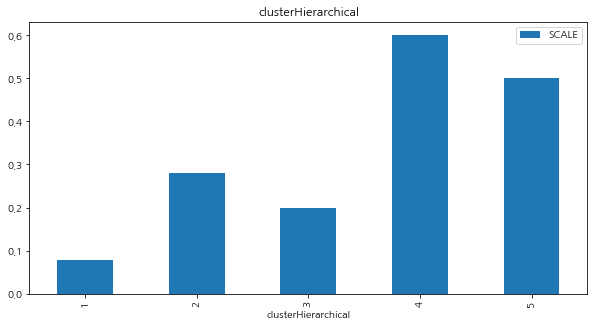

In [75]:
df_cluster_eda_avg = mer.groupby(["clusterHierarchical"], as_index=False)['SCALE'].mean()
df_cluster_eda_avg.plot(x = 'clusterHierarchical', y = 'SCALE', kind='bar', figsize=(10,5))
plt.title('clusterHierarchical')
plt.show()

In [76]:
mer['clusterHierarchical'].value_counts()

2    275
4    223
1    191
3     20
5      2
Name: clusterHierarchical, dtype: int64

66개의 제품규격(SPEC)에 대해 군집분석을 수행해 5개의 군집으로 나눈 후 각 그룹에 대한 scale 불량률을 살펴보았다.  
그룹 4와 5의 경우 scale 불량률이 높은 것을 확인할 수 있었다.  
하지만 이때 그룹 5의 경우 표본이 2개뿐이고 이때 각각 양품, 불량 한건씩 나타나 50%를 보였다.  
따라서 그룹 5의 결과는 제외하고 만약 새로운 데이터가 군집 분석을 통해 그룹 4와 같은 집합에 속한다면 scale 발생률이 높을 수 있다는 결론을 내릴 수 있다.

## 로지스틱 회귀

In [77]:
df_x_dummy = pd.get_dummies(df_raw_x) # df_raw_x변수 더미변수 만들기

In [78]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (497, 96)
train data Y size : (497,)
test data X size : (214, 96)
test data Y size : (214,)


In [79]:
# from_formula 함수를 이용하여 변수 역할 지정
# 분석 대상 이벤트 = “1”
log_model = Logit.from_formula("""SCALE ~C(STEEL_KIND) + PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO)+
                                    FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_TIME + ROLLING_TEMP_T5+
                                    C(HSB) + ROLLING_DESCALING + C(WORK_GR) + C(clusterHierarchical)""", 
                                 mer)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.268488
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  711
Model:                          Logit   Df Residuals:                      682
Method:                           MLE   Df Model:                           28
Date:                Sun, 11 Jul 2021   Pseudo R-squ.:                  0.5742
Time:                        12:42:39   Log-Likelihood:                -190.90
converged:                      False   LL-Null:                       -448.29
Covariance Type:            nonrobust   LLR p-value:                 6.047e-91
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      40.3702   2.56e+04      0.002      0.999   -5.01e+04    5.02e+04
C(STEEL_KIND)[

/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


로지스틱 회귀 결과 모델의 설명력은 0.5742으로 나타났다.  
회귀 계수를 검정한 결과 이 중에서 WORK_GR가 2조일때, FUR_HZ_TIME, FUR_HZ_TEMP, PT_WDTH, ROLLING_TEMP_T5, ROLLING_DESCALING일때 설명력의 영향이 있다고 볼 수 있다.

### 로지스틱회귀 설명변수 중요도 확인

<AxesSubplot:>

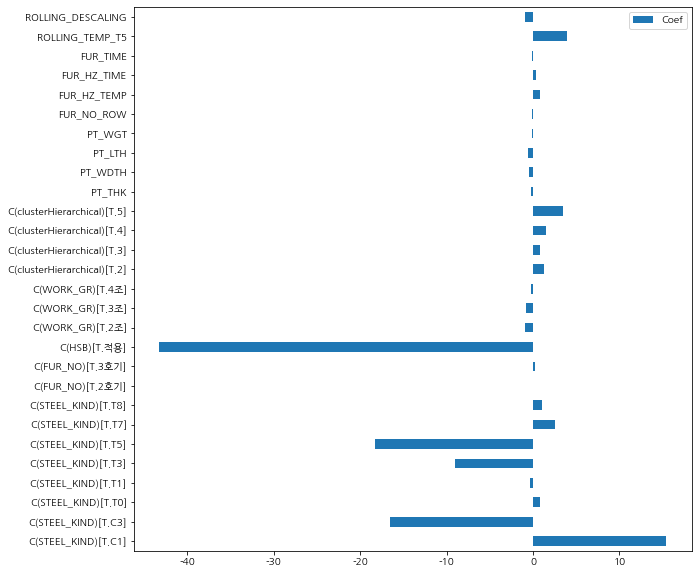

In [80]:
df_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef", figsize = (10, 10))

로지스틱 회귀 결과 모델의 설명력 :  0.5742

양의 상관도일때 1(불량)일 가능성이 높아지는 것이고
음의 상관도일때 0(양품)일 가능성이 높아지는 것이다.

회귀 계수를 검정한 결과 이 중에서 WORK_GR가 2조일때, FUR_HZ_TIME, FUR_HZ_TEMP, PT_WDTH, ROLLING_TEMP_T5, ROLLING_DESCALING일때 설명력의 영향이 있다고 볼 수 있었다.

영향력이 가장 큰 변수 : HSB라고 나타나 있지만 위에서 검정한 p-value값에 의해 영향력있는 변수라고 보지 않는다.

In [81]:
df_logistic_coef.sort_values("Coef", ascending = False, inplace = True)
df_logistic_coef

,Coef
C(STEEL_KIND)[T.C1],15.437945
ROLLING_TEMP_T5,3.985426
C(clusterHierarchical)[T.5],3.518883
C(STEEL_KIND)[T.T7],2.594763
C(clusterHierarchical)[T.4],1.453942
C(clusterHierarchical)[T.2],1.228251
C(STEEL_KIND)[T.T8],0.999097
FUR_HZ_TEMP,0.861341
C(clusterHierarchical)[T.3],0.835706
C(STEEL_KIND)[T.T0],0.787408


WORK_GR가 2조 : -0.979460  
FUR_HZ_TIME : 0.351176   
FUR_HZ_TEMP : 0.861341  
PT_WDTH : -0.451095 
ROLLING_TEMP_T5 : 3.985426
ROLLING_DESCALING : -0.972038

**변수 설명력 : ROLLING_TEMP_T5 > WORK_GR가 2조 > ROLLING_DESCALING > FUR_HZ_TEMP > PT_WDTH > FUR_HZ_TIME**

## 의사결정나무

In [82]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accucary on training set: 1.000
Accucary on test set: 0.963


#### 1) Parameter 범위 지정

In [83]:
para_depth = [depth for depth in range(1, 15)] # max_depth: 최대 깊이 변경
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)] # min_samples_leaf: 잎사귀 수 제한
para_split = [n_split * 2 for n_split in range(1, 11)] # min_samples_split: 분할하기 위한 노드의 최소 샘플 수 

#### 2) GridSearchCV를 활용한 의사결정나무

In [84]:
estimator = DecisionTreeClassifier(random_state = 1234)
param_grid = {"max_depth": para_depth,
              "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=20,
                       random_state=1234)

best parameter: 
{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 20}

best score: 
0.986


In [85]:
tree_final = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 5, min_samples_split = 20, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=20,
                       random_state=1234)

In [86]:
# 평가
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.986

Confusion matrix: 
[[138   1]
 [  2  73]]


#### 3) 설명변수 중요도 확인 및 테이블로 저장

In [87]:
# 변수명
feature_names = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = feature_names
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
10,ROLLING_TEMP_T5,0.613
90,HSB_미적용,0.145
9,FUR_EXTEMP,0.143
0,PT_THK,0.085
11,ROLLING_DESCALING,0.012
2,PT_LTH,0.002
61,SPEC_LR-EH36-TM,0.000
70,SPEC_NV-B,0.000
69,SPEC_NV-A36-TM,0.000
68,SPEC_NV-A32-TM,0.000


#### 4) 결론  
의사결정나무 모델 설명력 : 0.986  
**변수 설명력 : ROLLING_TEMP_T5 > HSB_미적용 > FU  R_EXTEMP > PT_THK > ROLLING_DESCALING > PT_LTH**  
scale 불량일때 정상으로 보는 경우가 2건 존재한다.


## 랜덤포레스트


In [88]:
rf_uncustomized = RandomForestClassifier(random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Accucary on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

print("Accucary on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accucary on training set: 1.000
Accucary on test set: 0.944


#### 1) Parameter 범위 지정

In [89]:
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]
para_split = [n_split * 1 for n_split in range(2,21)]
para_depth = [n_depth for n_depth in range(1,11)]

In [90]:
oob_error = []
for v_n_estimator in range(1,151):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    oob_error.append(1-rf.oob_score_)

/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/piai/anaconda3/envs/bigdata/lib/python3.7/site-package

Text(0.5, 0, 'n_estimators')

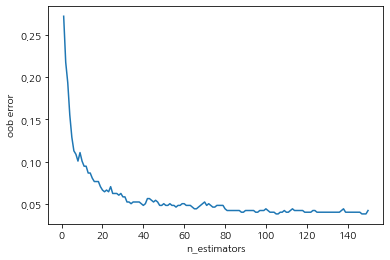

In [91]:
plt.plot(range(1,151), oob_error)
plt.ylabel("oob error")
plt.xlabel('n_estimators')

In [92]:
n_estimators = 30

#### 2) GridSearchCV를 활용한 랜덤포레스트

In [93]:
estimator = RandomForestClassifier(n_estimators = 30,random_state = 1234)
param_grid = {"min_samples_split": para_split,
              "min_samples_leaf": para_leaf,
              "max_depth" : para_depth,
              "n_estimators" : para_n_tree}

grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=20,
                       random_state=1234)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}

best score: 
0.956


In [94]:
rf_final = RandomForestClassifier(random_state=1234, max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 20)
rf_final.fit(df_train_x, df_train_y)

y_pred = rf_final.predict(df_test_x)
print("Accuracy of training set: {0:.3f}\n".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy of test set: {0:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy of training set: 0.974

Accuracy of test set: 0.949

Confusion matrix: 
[[139   0]
 [ 11  64]]


#### 3) 설명변수 중요도 확인 및 테이블로 저장

In [95]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(30)

,Feature,Importance
10,ROLLING_TEMP_T5,0.390
9,FUR_EXTEMP,0.102
1,PT_WDTH,0.078
90,HSB_미적용,0.070
5,FUR_HZ_TEMP,0.043
11,ROLLING_DESCALING,0.041
2,PT_LTH,0.035
7,FUR_SZ_TIME,0.032
8,FUR_TIME,0.028
91,HSB_적용,0.025


Text(0, 0.5, '설명변수')

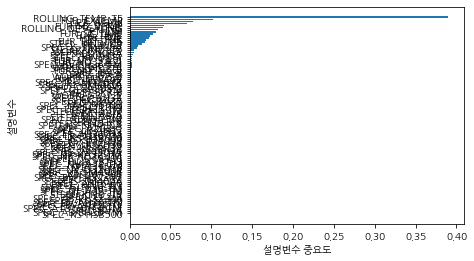

In [96]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

#### 4) 결론
랜덤포레스트 모델 설명력 : 0.949   
**변수 설명력 : ROLLING_TEMP_T5 > FUR_EXTEMP > PT_WDTH > HSB_미적용 > FUR_HZ_TEMP > ROLLING_DESCALING > PT_LTH > FUR_SZ_TIME > FUR_TIME**  
scale 불량일때 정상으로 보는 경우가 11건 존재한다.

## 그래디언트부스팅

In [97]:
gb_uncustiomized = GradientBoostingClassifier(random_state=1234)
gb_uncustiomized.fit(df_train_x,df_train_y)

print('score on training set : {:.3f}'.format(gb_uncustiomized.score(df_train_x, df_train_y)))
print('score on test set : {:.3f}'.format(gb_uncustiomized.score(df_test_x, df_test_y)))

gb_uncustiomized

score on training set : 1.000
score on test set : 0.981


GradientBoostingClassifier(random_state=1234)

#### 1) Parameter 범위 지정

In [98]:
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]
para_leaf = [n_leaf * 1 for n_leaf in range(1,40)]
para_split = [n_split * 2 for n_split in range(1,31)]
para_depth = [n_depth for n_depth in range(1,11)]
para_lr = [lr * 0.1 for lr in range(1,10)]

#### 2) GridSearchCV를 활용한 그래디언트부스팅

In [135]:
estimator = GradientBoostingClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"learning_rate": para_lr,
              "max_depth": para_depth,
              "min_samples_leaf": para_leaf}

# 정확도가 높은 최적 parameter 찾기
grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_gb.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

best estimator model: 
GradientBoostingClassifier(learning_rate=0.2, max_depth=8, random_state=1234)

best parameter: 
{'learning_rate': 0.2, 'max_depth': 8, 'min_samples_leaf': 1}

best score: 
0.99


#### 3) 설명변수 중요도 확인 및 테이블로 저장


In [137]:
gb_final = GradientBoostingClassifier(random_state = 1234, min_samples_leaf = 1, max_depth = 8, learning_rate = 0.2)
gb_final.fit(df_train_x, df_train_y)

y_pred = gb_final.predict(df_test_x)
print("Accuracy of training set: {0:.3f}\n".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy of test set: {0:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy of training set: 1.000

Accuracy of test set: 0.972

Confusion matrix: 
[[139   0]
 [  6  69]]


In [138]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = gb_fianl.feature_importances_
df_importance.sort_values("importance", ascending=False, inplace=True)
df_importance.round(3).head(10)

,Feature,importance
10,ROLLING_TEMP_T5,0.575
9,FUR_EXTEMP,0.138
90,HSB_미적용,0.078
11,ROLLING_DESCALING,0.066
91,HSB_적용,0.062
0,PT_THK,0.035
7,FUR_SZ_TIME,0.013
3,PT_WGT,0.005
1,PT_WDTH,0.004
16,SPEC_AB/A,0.004


Text(0, 0.5, '변수')

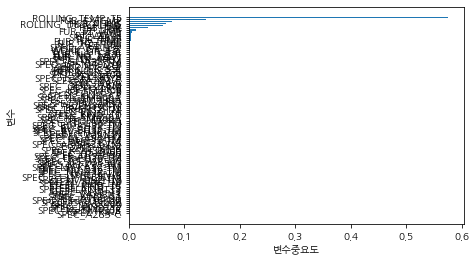

In [139]:
df_importance.sort_values("importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")

#### 4) 결론
그래디언트부스팅 모델 설명력 : 0.972  
**변수 설명력 : ROLLING_TEMP_T5 > FUR_EXTEMP > HSB_미적용 > ROLLING_DESCALING > HSB_적용 > PT_THK > FUR_SZ_TIME**    
scale 불량일때 정상으로 보는 경우가 6건 존재한다.

## SVM

In [114]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

svm_uncustomized

Accuracy on train set: 0.911
Accuracy on test set: 0.850


SVC(random_state=1234)

#### 1) Parameter 범위 지정

In [117]:
para_c = [10 **c for c in range(-5, 5)]
para_gamma = [10 **gamma for gamma in range(-5, 5)]

#### 2) GridSearchCV를 활용한 SVM

In [121]:
estimator = SVC(random_state = 1234)

# 구하고자 하는 parameter와 범위
param_grid = {"C": para_c,
              "gamma": para_gamma}

# 정확도가 높은 최적 parameter 찾기
grid_svm = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_svm.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_svm.best_estimator_))
print("\nbest parameter: \n{}".format(grid_svm.best_params_))
print("\nbest score: \n{}".format(grid_svm.best_score_.round(3)))

best estimator model: 
SVC(C=10, gamma=0.01, random_state=1234)

best parameter: 
{'C': 10, 'gamma': 0.01}

best score: 
0.865


#### 3) 설명변수 중요도 확인 및 테이블로 저장

In [122]:
# 최종 모델
svc_final = SVC(gamma = 0.01, C = 10, random_state = 1234)
svc_final.fit(df_train_x, df_train_y)

# 평가
y_pred = svc_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accucary on training set: 0.915
Accuracy on test set: 0.850

Confusion matrix: 
[[129  10]
 [ 22  53]]


#### 4) 결론
svm 모델 설명력 : 0.850   
scale 불량일때 정상으로 보는 경우가 22건 존재한다.

## 최종 결론

**모델 정확도**  
로지스틱 회귀 결과 모델의 설명력 : 0.5742  
의사결정나무 모델 설명력 : 0.986  
랜덤포레스트 모델 설명력 : 0.949  
그래디언트부스팅 모델 설명력 : 0.972  

=> scale 불량일때 정상으로 보는 경우가 2건으로 예측하는 의사결정나무 모델을 설명변수의 중요도를 선택하고자 한다.  
**변수 설명력 : ROLLING_TEMP_T5 > HSB_미적용 > FUR_EXTEMP > PT_THK > ROLLING_DESCALING > PT_LTH**

**scale 발생을 줄이는 방법**
1. ROLLING_TEMP_T5(압연온도)를 낮춘다.
2. HSB(후판 공장에서 가열중 발생되는 1차 Scale 제거장치)를 적용한다.
3. FUR_EXTEMP(추출온도)를 낮춘다. 
4. PT_THK(plate 두께)를 줄인다.
5. ROLLING_DESCALING(압연 중 descaling 횟수)를 늘린다.
6. PT_LTH(plath 길이)를 늘린다.